**Detecting circles via MLE**

A more high level example - using MLE to detect circles in a 2D point cloud generated by our RADAR / LIDAR. Based on Zelniker et al.

In [59]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats, optimize

In [60]:
objects = [
    {"x": -12, "y": 12, "r": 4, "spin": 20}
]

radar_x = 3
radar_y = 4

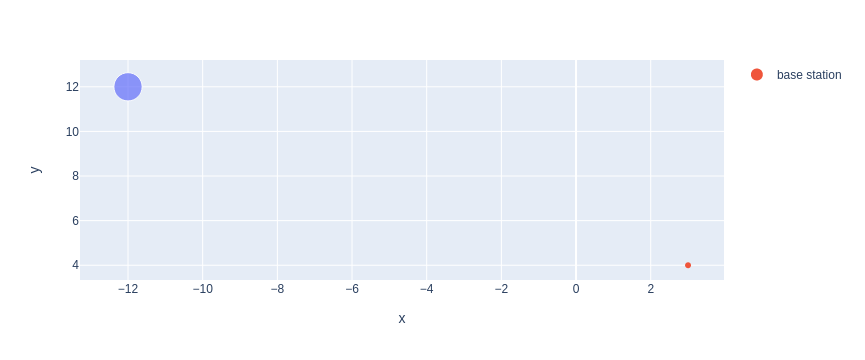

In [61]:
fig = px.scatter(
    x = [o["x"] for o in objects],
    y = [o["y"] for o in objects],
    size = [o["r"] for o in objects],
)
fig.add_scatter(x=[radar_x], y=[radar_y], mode="markers", name="base station")
fig.show()

In [63]:
num_angles = 8000
point_xs = []
point_ys = []
point_vs = []
point_angles = []
point_clouds = []

for angle in np.linspace(0, 2*np.pi, num_angles):
    Dx = np.cos(angle)
    Dy = np.sin(angle)
    min_t = float("inf")
    for obj in objects:
        
  
        hit = None

        # Look ray from radar to object
        Lx = obj["x"] - radar_x
        Ly = obj["y"] - radar_y
        tca = Dx*Lx + Dy*Ly
        if tca < 0:
            continue
        try:
            d = np.sqrt(Lx*Lx+Ly*Ly - tca*tca)
            thc = np.sqrt(obj["r"]*obj["r"] - d*d)
        except:
            # imaginary root
            continue
        
        # ray hit distance
        t = min(tca+thc, tca-thc)
        
        # if hit distance is the smallest so far (ie. forward object shadows rear object)
        if t < min_t:
            # hit pos
            hx = radar_x + Dx * t
            hy = radar_y + Dy * t
            
            # Calculate velocity in the direction of the radar (TODO maybe wrong)
            hit_angle = np.arctan2(hx - obj["x"], hy-obj["y"])
            incident_angle = np.arctan2(radar_x - obj["x"], radar_y - obj["y"])
            # Find difference between incident angle and hit angle (without wrapping artifacts)
            # functionally same as d_angle = hit_angle - incident_angle
            d_angle = np.arctan2(
                np.sin(hit_angle - incident_angle), 
                np.cos(hit_angle - incident_angle)
            )
            velo = obj["spin"] * np.sin(d_angle)
            
            # add noise to hit pos
            hx_noise = hx + np.random.normal(scale=0.2)
            hy_noise = hy + np.random.normal(scale=0.2)
            # store hit
            hit = (hx_noise, hy_noise, velo, angle)
            # store min hit distance at this angle
            min_t = t
        if hit is not None:
            point_xs.append(hit[0])
            point_ys.append(hit[1])
            point_vs.append(hit[2])
            point_angles.append(hit[3])

# x pos
point_xs = np.array(point_xs)
# y pos
point_ys = np.array(point_ys)
# velocity in direction of radar (proportional to doppler shift)
point_vs = np.array(point_vs)
# angle that the radar is facing when it collected this point
point_angles = np.array(point_angles)

/home/dippie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in sqrt



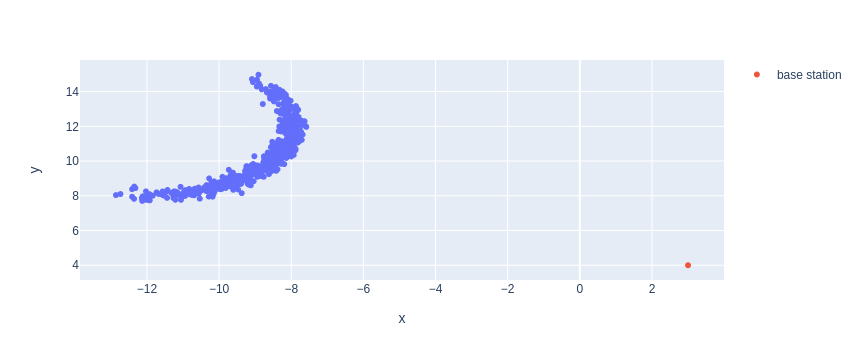

In [64]:
fig = px.scatter(x=point_xs, y=point_ys)
fig.add_scatter(x=[radar_x], y=[radar_y], mode="markers", name="base station")

fig.show()

How can MLE find the original circle in this point cloud?

Let each found point be $\vec{p_i}$, let the (actual) center be $\vec{c}$, and define the unit circle as $\vec{u}(\theta_i) = \begin{bmatrix}cos(\theta_i)\\sin(\theta_i) \end{bmatrix}$. 

Thus $\vec{p}_i = \vec{c} + r \cdot \vec{u}(\theta_i)$. Assume each $\vec{p}_i$ Gaussian distributed (independently). 

So, can define a likelihood func. of getting every point: 

$$ L(\vec{c}, r, \vec{p}_1 ... \vec{p}_N) = \frac{1}{2\pi\sigma^2}\prod^N_{i=1} exp \left( \frac{ -\|\vec{p}_i - (\vec{c}+r\cdot \vec{u}(\theta_i)\|^2}{2\sigma^2} \right) $$ 

Take log of the likelihood. Product of exponents turns into a sum. Can discard constant terms as we want to **maximize** likelihood. After some algebra, we get:

$$ln(L(\vec{p}, r)) = \sum^N_{i=1}(\| \vec{p}_i - c \| - r)^2$$

Use the computer to get $\vec{p}$ and $r$.

In [72]:
def gen_log_likelihood(x_values, y_values):
    def likelihood_fn(params):
        cx, cy, r = params[0], params[1], params[2]
        
        norm = np.sqrt(np.square(x_values - cx) + np.square(y_values - cy))
        return np.sum(np.square(norm - r))
    return likelihood_fn

In [66]:
closest_idx = np.argmin(
    np.sqrt(
        np.square(point_xs - radar_x) +
        np.square(point_ys - radar_y)
    )
)
guess = np.array([point_xs[closest_idx], point_ys[closest_idx], 1.0])

In [67]:
guess_x = np.mean(point_xs)
guess_y = np.mean(point_ys)
guess = np.array([guess_x, guess_y, 1.0])
guess

array([-8.97622676, 10.37949556,  1.        ])

In [68]:
opt_res = optimize.minimize(
    gen_log_likelihood(point_xs, point_ys),
    guess,
    options={"disp": True}
)
opt_res

Optimization terminated successfully.
         Current function value: 21.598591
         Iterations: 17
         Function evaluations: 88
         Gradient evaluations: 22


      fun: 21.5985909865747
 hess_inv: array([[ 0.02713156, -0.01271979, -0.02584128],
       [-0.01271979,  0.01028508,  0.01392226],
       [-0.02584128,  0.01392226,  0.02616421]])
      jac: array([ 3.33786011e-06, -2.38418579e-06,  4.52995300e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 17
     njev: 22
   status: 0
  success: True
        x: array([-11.99634091,  12.02401343,   4.01174859])

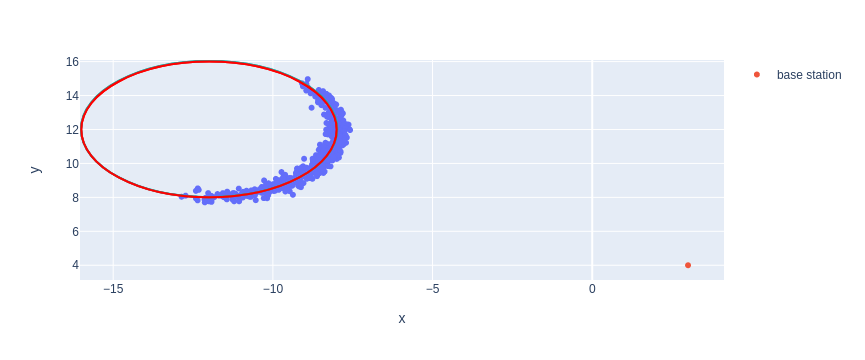

In [71]:
px, py, r = opt_res.x

# Draw fit circle
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=px-r, y0=py-r, x1=px+r, y1=py+r,
    line_color="LightSeaGreen",
)

for o in objects:
    # Draw real circle
    fig.add_shape(type="circle",
        xref="x", yref="y",
        x0=o["x"]-o["r"], y0=o["y"]-o["r"], x1=o["x"]+o["r"], y1=o["y"]+o["r"],
        line_color="Red",
    )

fig.show()
